In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats import expon


En este informe realizaremos un estudio de inferencia Bayesiana para determinar los parametros de la función luminosidad utilizando Cadenas de Markov, los algoritmos que vamos a implementar en este metodo son 'Metropolis Hastings' y 'Gradiente Descendiente'. 

Para ello vamos a utilizar los datos de Blanton et al. 2001, que contiene la densidad de galaxias por magnitud absoluta.

In [2]:
# Lee el archivo CSV
df = pd.read_csv('datos_Blanton2001.csv')

In [3]:
yerr2= (df.iloc[:, 2]+ df.iloc[:, 3])/2

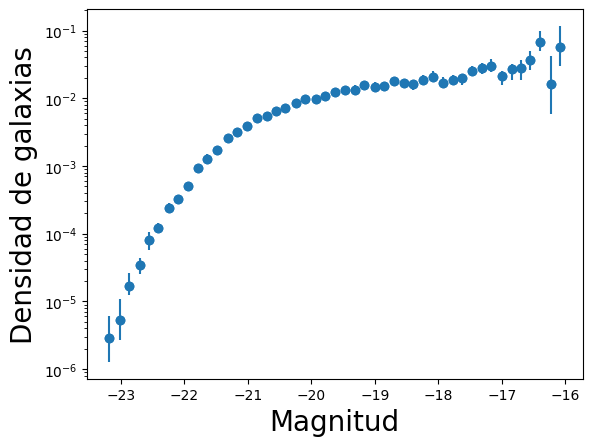

In [4]:
plt.scatter(df.iloc[:, 0], df.iloc[:, 1])
plt.errorbar(df.iloc[:, 0], df.iloc[:, 1],yerr= [df.iloc[:, 2], df.iloc[:, 3]],marker='o',ls='')
plt.yscale('log')
plt.xlabel('Magnitud', fontsize=20)
plt.ylabel('Densidad de galaxias', fontsize=20)
#plt.legend(fontsize=12, loc='best')
plt.show()

## Función de Schechter 
La Función de Schechter es una función que describe la distribución de luminosidades o masas de galaxias en el universo. Está definida como:
$$
\Phi(M) \, dM = 0.4 \, \ln(10) \, \Phi^* \, 10^{-0.4 (M - M^*) (\alpha + 1)} \, \exp\left(-10^{-0.4 (M - M^*)}\right) \, dM
$$

Donde los parametros que nos van a interesar son $M^*$, $\alpha$, $\Phi^*$.


In [5]:
# Definir la función Φ(M)
def phi_M(M, phi_star, M_star, alpha):
    # Constante frente a la fórmula
    constante = 0.4 * np.log(10)
    
    # Primera parte de la fórmula: 10^(-0.4(M - M*))(α + 1)
    term1 = 10 ** (-0.4 * (M - M_star) * (alpha + 1))
    
    # Segunda parte: exp(10^(-0.4(M - M*)))
    term2 = np.exp(-10 ** (-0.4 * (M - M_star)))
    
    # La función completa Φ(M)
    phi = constante * phi_star * term1 * term2
    
    return phi

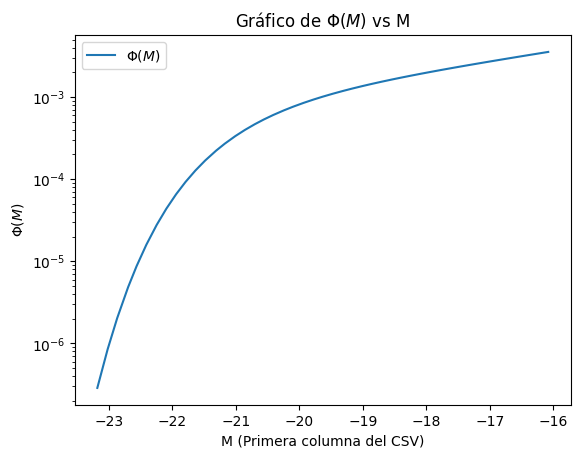

In [6]:
# Extraer la primera columna como los valores de M
M = df.iloc[:, 0].values

# Definir los parámetros de la función Φ(M)
phi_star = 1e-3  # Un valor de Φ*
M_star = -21  # Un valor de M*
alpha = -1.3  # Un valor de α

# Calcular Φ(M) para cada valor de M en la primera columna
phi_values = phi_M(M, phi_star, M_star, alpha)

# Graficar Φ(M) en función de M (primera columna)
plt.plot(M, phi_values, label=r'$\Phi(M)$')

# Añadir etiquetas a los ejes
plt.yscale('log')
plt.xlabel('M (Primera columna del CSV)')
plt.ylabel(r'$\Phi(M)$')

# Añadir un título y una leyenda
plt.title(r'Gráfico de $\Phi(M)$ vs M')
plt.legend()

# Mostrar el gráfico
plt.show()


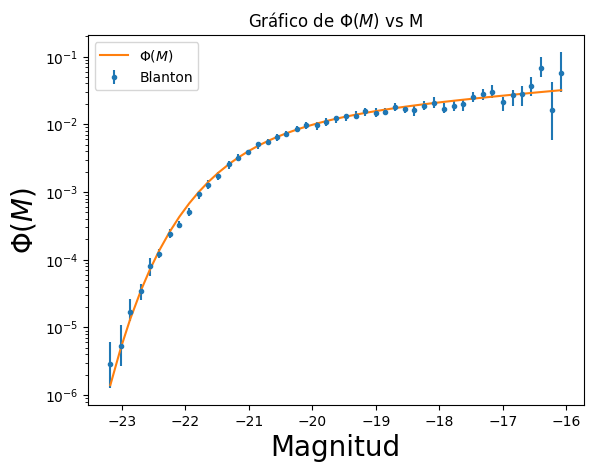

In [7]:
plt.errorbar(df.iloc[:, 0], df.iloc[:, 1],yerr= [df.iloc[:, 2], df.iloc[:, 3]],marker='o',ls='',ms=3,label=r'Blanton')
plt.yscale('log')
plt.xlabel('Magnitud', fontsize=20)
plt.ylabel('Densidad de galaxias', fontsize=20)

M = df.iloc[:, 0].values

# Definir los parámetros de la función Φ(M)
M = df.iloc[:, 0].values
phi_star = 14.6e-3  # Un valor de Φ*
M_star = -20.83  # Un valor de M*
alpha_star= -1.20 # Un valor de α

# Calcular Φ(M) para cada valor de M en la primera columna
phi_values = phi_M(M, phi_star, M_star, alpha_star)

# Graficar Φ(M) en función de M (primera columna)
plt.plot(M, phi_values, label=r'$\Phi(M)$')
plt.yscale('log')
plt.xlabel('Magnitud')
plt.ylabel(r'$\Phi(M)$')
plt.title(r'Gráfico de $\Phi(M)$ vs M')
plt.legend()
plt.show()

En el grafico de arriba podemos ver como ajusta la funcion de Schechter, utilizando los parametros de la literatura a los datos observacionales.

# Cadenas de Markov

#### Ahora queremos explorar el espacio de parametros de esta función para estimar cual es la distribucion de probabilidad posterior de los parametros del modelo. Esto lo haremos con las 'Monte Carlo Markov Chains'. 

## Metropolis-Hastings
La idea de este metodo es inicializar los parametros aleatoriamente con un valor cercano a los valores de literatura y se calcula la probabilidad a posteriori, luego se da un salto en el espacio de parametros y se calcula nuevamente la posteriori, si es mas alta, me quedo con esos parametros y si es mas baja se da un criterio para aceptar o rechazar esos parametros, esto se hace iterativamente hasta que las cadenas converjan.

## Probabilidad Posteriori

La probabilidad posteriori es la probabilidad de un conjunto de parámetros $\theta$ dados los datos observados $(D)$. Se calcula utilizando el Teorema de Bayes y representa la actualización de nuestro conocimiento sobre los parámetros después de observar los datos. Matemáticamente, se define como:

$P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}$


* $P(\theta | D)$ es la probabilidad posterior de los parámetros $\theta$ dados los datos $D$.
* $P(D | \theta)$ es el likelihood, que mide la probabilidad de observar los datos $D$ para un valor dado de $\theta$.
* $P(\theta)$ es la Prior o probabilidad previa de $\theta$, que representa nuestro conocimiento sobre los parámetros antes de observar los datos.
* $P(D)$ es la evidencia, que actúa como un factor de normalización para asegurar que la probabilidad posterior sea una distribución válida.(En nuestro caso la utilizaremos como 1)


La probabilidad posterior refleja toda la información disponible sobre los parámetros tras haber observado los datos.


In [8]:
def prior(philim,alim,Mlim,phi_star, alpha_star,M_star):
    if (alpha_star<alim[1]) & (alpha_star>alim[0]) & (M_star<Mlim[1]) &( M_star>Mlim[0]) & (phi_star<philim[1]) & (phi_star>philim[0]):
        return 1
    else:
        return 0

In [9]:
df['sigma'] = (df.loc[:, 'error_inf']+ df.loc[:, 'error_sup'])/2
df.head()

MAG       PHI  error_inf  error_sup     sigma
0 -23.183  0.000003   0.000002   0.000003  0.000002
1 -23.020  0.000005   0.000003   0.000005  0.000004
2 -22.870  0.000017   0.000005   0.000009  0.000007
3 -22.698  0.000035   0.000009   0.000010  0.000009
4 -22.565  0.000082   0.000024   0.000023  0.000023

In [10]:
#Defino likelihood
datos_phi = df.iloc[:, 1].values
sigma= (df.iloc[:, 2]+ df.iloc[:, 3])/2

def likelihood( M , datos_phi ,M_star, phi_star, alpha_star ,sigma): #(star son los parametros de shcner)
    z=phi_M(M,phi_star,M_star,alpha_star)
    x=((datos_phi - z)/sigma)**2
    x2=np.sum(x)
    l=np.exp(-x2/2)
    return l

In [11]:
#Defino posteriori
def posteriori(M_star,phi_star,alpha_star, M, datos_phi,sigma,philim,alim,Mlim):
    post = likelihood(M,datos_phi,M_star,phi_star,alpha_star,sigma)*prior(philim,alim,Mlim,phi_star,alpha_star,M_star)
    return post

In [87]:
def metropolis_hastings (l,f):
    N = 2000 #pasos

    param1 =  initial_params
    M_star,phi_star,alpha_star =  param1 

    p1 = posteriori(M_star,phi_star,alpha_star, l, f,sigma,philim,alim,Mlim)

    params = np.zeros([N,3])
    posterior = np.zeros([N,1])

    j = 0
    while  j < N:
        param1 = np.array(param1)
        param2 = param1 + np.random.normal(0, [1.e-1, 1.e-4, 1.e-2])
        M_star,phi_star,alpha_star = param2

        if prior(philim,alim,Mlim,phi_star, alpha_star,M_star) == 1:

            p2 = posteriori(M_star,phi_star,alpha_star, l, f,sigma,philim,alim,Mlim)

            if p2 >= p1:
                params[j] = param2 
                posterior[j] = p2
                param1 = param2
                p1 = p2 
                j += 1
            else:
                u = p2/p1
                r = np.random.rand()
                if r < u:
                    params[j] = param2 
                    posterior[j] = p2
                    param1 = param2
                    p2 = p1 
                    j +=1
    params = params[:j]
    return params , posterior

In [105]:
# Parámetros iniciales y configuración
philim = [0.005,0.035]
alim = [-1.4,-1.0]
Mlim = [-22,-19]
initial_params = [
    np.random.uniform(Mlim[0], Mlim[1]),    # M*
    np.random.uniform(philim[0], philim[1]), # Φ*
    np.random.uniform(alim[0], alim[1])      # α
    ]  # Valores iniciales para M_star, phi_star, alpha

salida = metropolis_hastings(M,datos_phi)
salida

(array([[-2.13070786e+01,  1.94160679e-02, -1.04439036e+00],
        [-2.14746364e+01,  1.94982921e-02, -1.02844677e+00],
        [-2.16636395e+01,  1.95594170e-02, -1.02411549e+00],
        ...,
        [-2.07860524e+01,  1.48746612e-02, -1.18645313e+00],
        [-2.07710511e+01,  1.47398339e-02, -1.19202177e+00],
        [-2.07878100e+01,  1.48468060e-02, -1.18883602e+00]]),
 array([[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [2.82301935e-05],
        [1.48911821e-05],
        [2.60424637e-05]]))

In [106]:
posterior  = salida[1]
parametros = salida[0]

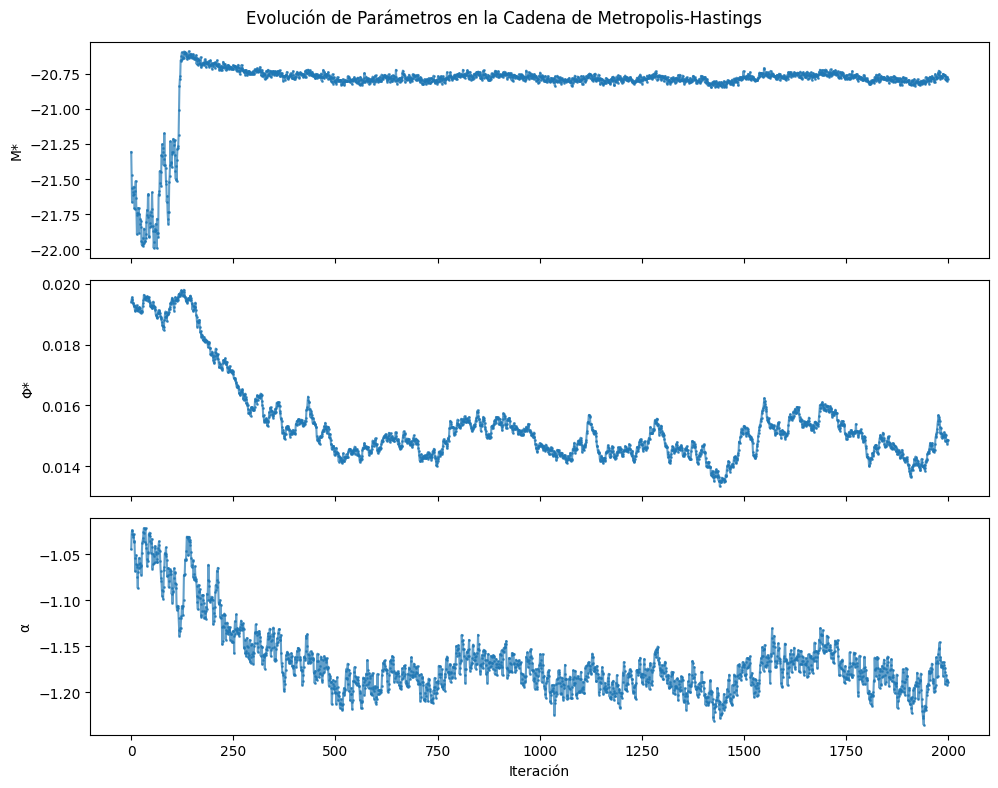

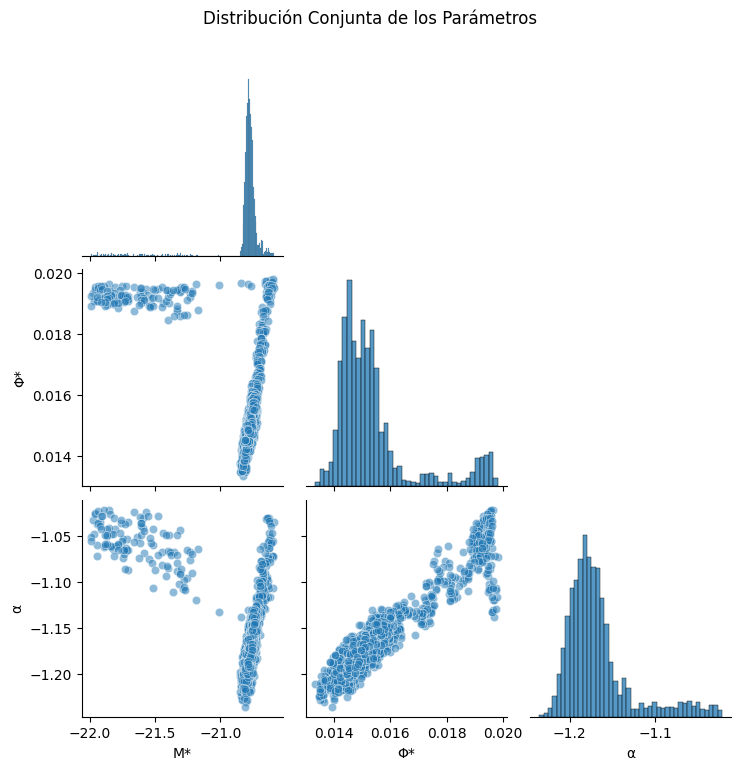

In [107]:
param_labels = ['M*', 'Φ*', 'α']

# Graficar cada parámetro a lo largo de las iteraciones
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axs[i].plot(parametros[:, i], marker='o', linestyle='-', markersize=1, alpha=0.7)
    axs[i].set_ylabel(param_labels[i])
axs[-1].set_xlabel("Iteración")
plt.suptitle("Evolución de Parámetros en la Cadena de Metropolis-Hastings")
plt.tight_layout()
plt.show()

# Graficar el corner plot
param_df = pd.DataFrame(parametros, columns=param_labels)

sns.pairplot(param_df, corner=True, plot_kws={'alpha': 0.5})
plt.suptitle("Distribución Conjunta de los Parámetros", y=1.02)
plt.show()


Ahora queremos hacer lo mismo pero con varias cadenas al mismo tiempo, para poder muestrear bien el espacio de parametros

Veamos como se produce un buen y un mal mezaclado de las cadenas. Para el mal mezclado vamos a permitir que los parametros inciales puedan inicialisarze unicamente en una mitad de los priors de cada parametro, y para el buen mezclado vamos a hacer un inicializado random dentro de los priors.

In [108]:
# Parámetros iniciales y configuración
philim = [0.005,0.035]
alim = [-1.4,-1.0]
Mlim = [-22,-19]
chains = []

for i in range(20):

    initial_params = [
        np.random.uniform(Mlim[0], -21),    # M*
        np.random.uniform(philim[0], 0.02), # Φ*
        np.random.uniform(alim[0], -1.2)      # α
        ]
    par = metropolis_hastings(M,datos_phi)[0]
    chains.append(par)

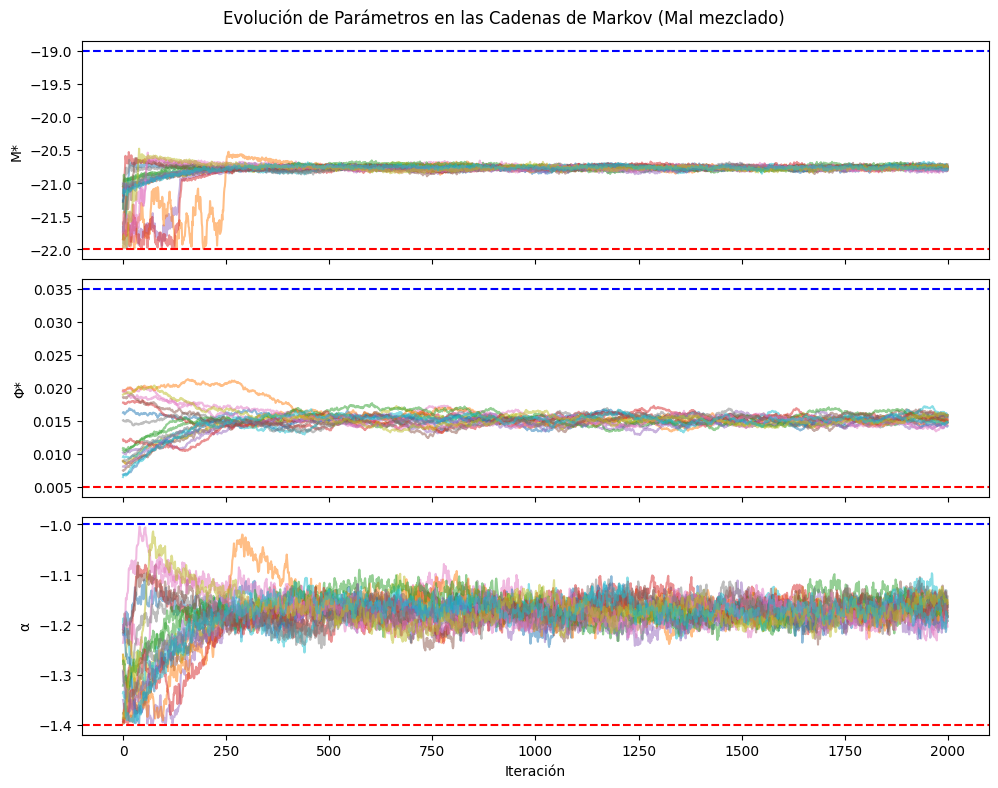

In [109]:
chains = np.array(chains)
param_labels = ['M*', 'Φ*', 'α']
param_limits = [Mlim, philim, alim]  # Límites para cada parámetro

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    # Graficar cada cadena
    for j in range(chains.shape[0]):
        axs[i].plot(chains[j, :, i], alpha=0.5, label=f'Cadena {j+1}' if i == 0 else "")
    
    # Agregar líneas para los límites inferior y superior del parámetro
    axs[i].axhline(param_limits[i][0], color='red', linestyle='--', label=f'Límite inferior {param_labels[i]}' if j == 0 else "")
    axs[i].axhline(param_limits[i][1], color='blue', linestyle='--', label=f'Límite superior {param_labels[i]}' if j == 0 else "")
    
    # Etiqueta del eje Y
    axs[i].set_ylabel(param_labels[i])

axs[-1].set_xlabel("Iteración")
plt.suptitle("Evolución de Parámetros en las Cadenas de Markov (Mal mezclado)")
plt.tight_layout()
plt.show()


Ahora veamos con un buen mezclado de cadenas.

In [112]:
chains = []

for i in range(20):

    initial_params = [
        np.random.uniform(Mlim[0],Mlim[1]),    # M*
        np.random.uniform(philim[0],philim[1]), # Φ*
        np.random.uniform(alim[0], alim[1])      # α
        ]
    par = metropolis_hastings(M,datos_phi)[0]
    chains.append(par)

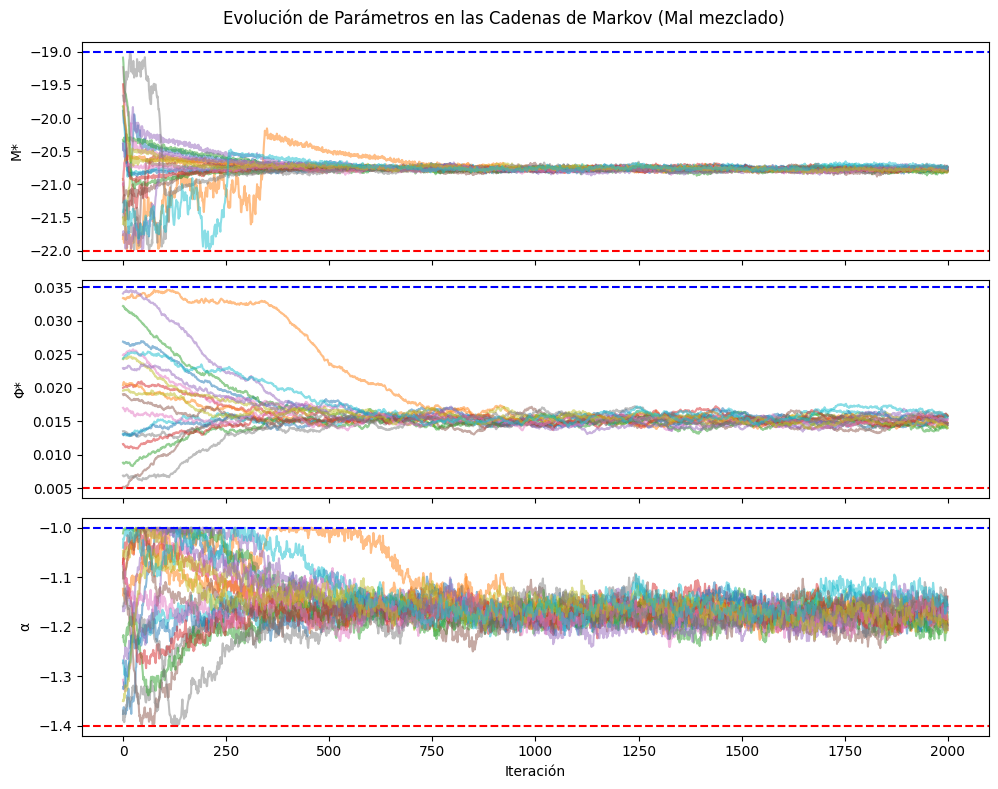

In [113]:
chains = np.array(chains)
param_labels = ['M*', 'Φ*', 'α']
param_limits = [Mlim, philim, alim]  # Límites para cada parámetro

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    # Graficar cada cadena
    for j in range(chains.shape[0]):
        axs[i].plot(chains[j, :, i], alpha=0.5, label=f'Cadena {j+1}' if i == 0 else "")
    
    # Agregar líneas para los límites inferior y superior del parámetro
    axs[i].axhline(param_limits[i][0], color='red', linestyle='--', label=f'Límite inferior {param_labels[i]}' if j == 0 else "")
    axs[i].axhline(param_limits[i][1], color='blue', linestyle='--', label=f'Límite superior {param_labels[i]}' if j == 0 else "")
    
    # Etiqueta del eje Y
    axs[i].set_ylabel(param_labels[i])

axs[-1].set_xlabel("Iteración")
plt.suptitle("Evolución de Parámetros en las Cadenas de Markov (Mal mezclado)")
plt.tight_layout()
plt.show()

En el grafico de arriba podemos observar como los parametros iniciales muestrean uniformemente todo el rango de los priors. Por último con este buen mezclado vamos a ver como son los graficos de esquina.

<function matplotlib.pyplot.show(close=None, block=None)>

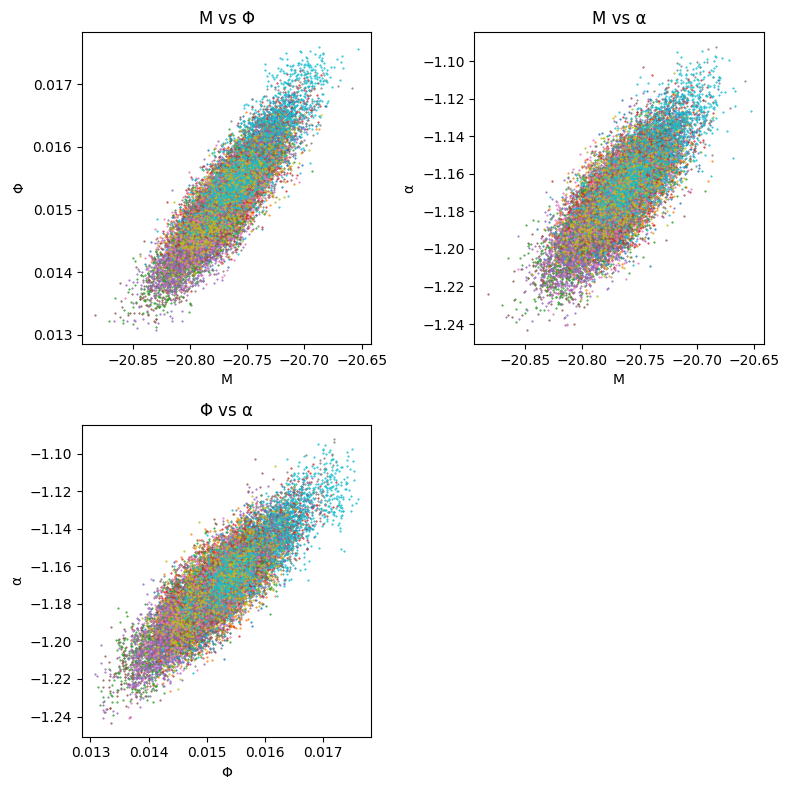

In [115]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
fig.delaxes(axs[1, 1])

plt.subplot
for i in range(20):
    ax1.plot(chains[i,1000:,0],chains[i,1000:,1],'.',ms=1)
    ax2.plot(chains[i,1000:,0],chains[i,1000:,2],'.',ms=1)
    ax3.plot(chains[i,1000:,1],chains[i,1000:,2],'.',ms=1)

ax1.set_xlabel("M")
ax1.set_ylabel("$\Phi$")

ax2.set_xlabel("M")
ax2.set_ylabel("α")

ax3.set_xlabel("$\Phi$")
ax3.set_ylabel("α")

ax1.set_title("M vs $\Phi$")
ax2.set_title("M vs α")
ax3.set_title("$\Phi$ vs α")

# Mostrar leyenda y ajustar diseño
plt.tight_layout()
plt.show

In [194]:
import plotly.graph_objects as go
# Crear una figura 3D con plotly
fig = go.Figure()

# Añadir las chains al gráfico
for i in range(10):  # Si tienes 10 chains en total
    fig.add_trace(go.Scatter3d(
        x=chains[i][:, 0],
        y=chains[i][:, 1],
        z=chains[i][:, 2],
        mode='lines',
        marker=dict(size=3),
        name=f'Cadena {i+1}'
    ))

# Añadir los puntos rojos para el último valor de cada cadena
for i in range(10):
    fig.add_trace(go.Scatter3d(
        x=[chains[i][-1, 0]],
        y=[chains[i][-1, 1]],
        z=[chains[i][-1, 2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name=f'Último punto cadena {i+1}'
    ))

# Añadir etiquetas y título
fig.update_layout(
    scene=dict(
        xaxis_title='M',
        yaxis_title='$\Phi$',
        zaxis_title='α'
    ),
    title='Gráfico 3D Interactivo de las Cadenas',
)

# Líneas para los parámetros de la literatura
phi_ref = 1.46e-2  # Reemplaza con el valor correspondiente
M_ref = -20.83    # Reemplaza con el valor correspondiente
alpha_ref = -1.2  # Reemplaza con el valor correspondiente

# Agregar la línea para alfa
fig.add_trace(go.Scatter3d(
    x=[M_ref, M_ref],
    y=[phi_ref, phi_ref],
    z=[-1, -1.4],   
    mode='lines',
    line=dict(color='black', width=6, dash='dash')
))

# Agregar la línea para alfa
fig.add_trace(go.Scatter3d(
    x=[-19.5,-23 ],
    y=[phi_ref, phi_ref],
    z=[alpha_ref, alpha_ref],   
    mode='lines',
    line=dict(color='black', width=6, dash='dash')
))

# Agregar la línea para alfa
fig.add_trace(go.Scatter3d(
    x=[M_ref, M_ref],
    y=[0, 0.04],
    z=[alpha_ref, alpha_ref],  
    mode='lines',
    line=dict(color='black', width=6, dash='dash'),
    name='Parametros literatura'
))


# Mostrar el gráfico
fig.show()

# Gradiente Descendiente

En esta parte, en vez de utilizar Metropolis-Hastings, utilizaremos el algoritmo de gradiente descendiente que consiste en moverse(siguiente eslabon de la cadena) en dirección contraria al gradiente de la función posteriori, que como nuestro prior es un prior plano, el gradiente de la funcion posteriori va ser simplemente el gradiente de la funcion likelihood, que queda de la siguiente forma:

$\nabla \ln P(\theta | \text{datos}) = \frac{(y - \text{datos})}{\sigma^2} \cdot \nabla \phi_{\text{modelo}}$

In [12]:
#Defino el gradiente de la funcion Schechtner
def grad_phi_M(M, phi_star, M_star, alpha_star):
    # Constante frente a la fórmula
    constante = 0.4 * np.log(10)
    
    # Terminos comunes
    delta_M = M_star - M
    exp_term =np.exp(-10 ** (0.4 * delta_M))
    power_term = 10 ** (0.4 * delta_M * (alpha_star + 1))
    
    # Φ(M)
    phi = constante * phi_star * power_term * exp_term
    
    # Derivadas parciales
    dphi_dphi_star = constante * power_term * exp_term
    dphi_dM_star = phi * (0.4 * np.log(10)) * ((alpha_star + 1) - (10 ** (0.4 * delta_M))) #aca cambie el menos por un mas despues de alpha + 1
    dphi_dalpha = phi * (np.log(10) * 0.4 * delta_M)
    
    return np.array([dphi_dphi_star, dphi_dM_star, dphi_dalpha])

In [13]:
#Defino el grad posteriori normalizado
def grad_posteriori(phi_star,M_star,alpha_star):
    t1 = -(df.loc[:,'PHI']-phi_M(df.loc[:,'MAG'],phi_star,M_star,alpha_star))/(df.loc[:,'sigma']**2)#(factor*)
    t2 = grad_phi_M(df.loc[:,'MAG'], phi_star, M_star, alpha_star)
    t3 = np.dot(t2,t1)
    t4 = t3/np.sqrt((t3[0]**2)+(t3[1]**2)+(t3[2]**2))
    return t4

### Cadenas de Markov con Gradientes.

In [14]:
def gra_des (M_star,phi_star,alpha_star):
    N = 1000 #pasos
    eta = 0.001 #tasa de aprendizaje
    #puedo definir una tolerancia tal que el paso dado sea menor a este numero

    p = initial_params
    params = np.zeros([N,3])
    i = 0
    for i in range(N):
        if i < 800:
            eta = 0.1
        else:
            eta = 0.01
        params[i] = p 
        p = p - eta*np.array([0.001,1,0.1])*grad_posteriori(p[0],p[1],p[2])

    return params

In [14]:
philim = [0.005,0.035]
alim = [-1.4,-1.0]
Mlim = [-22,-19]
initial_params = [
    np.random.uniform(philim[0], philim[1]), # Φ*
    np.random.uniform(Mlim[0], Mlim[1]),    # M*
    np.random.uniform(alim[0], alim[1])      # α
    ]  
parametros=gra_des(initial_params[0],initial_params[1],initial_params[2]) # phi, M, alpha
parametros

array([[ 1.10127513e-02, -1.92642663e+01, -1.02319622e+00],
       [ 1.11127443e-02, -1.92653783e+01, -1.02323740e+00],
       [ 1.12127371e-02, -1.92665022e+01, -1.02327878e+00],
       ...,
       [ 1.51122538e-02, -2.07709390e+01, -1.17316524e+00],
       [ 1.51222514e-02, -2.07711480e+01, -1.17317142e+00],
       [ 1.51122538e-02, -2.07709391e+01, -1.17316532e+00]])

In [15]:
print(parametros[-1,:])

[ 1.51122538e-02 -2.07709391e+01 -1.17316532e+00]


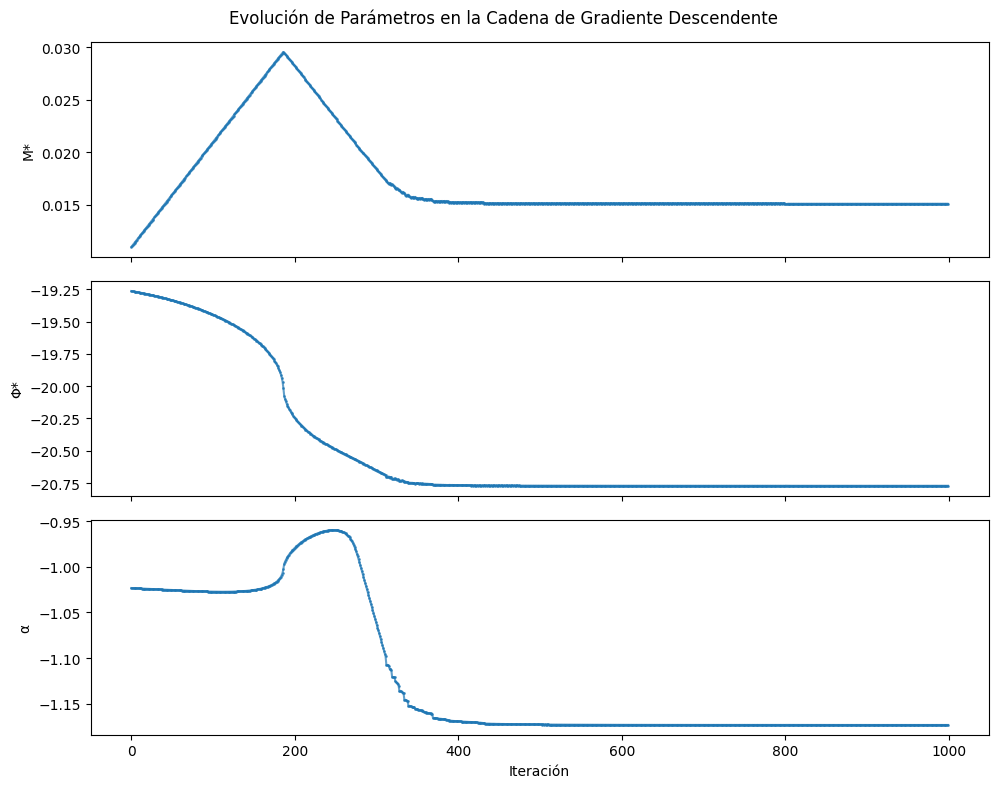

In [16]:
param_labels = ['M*', 'Φ*', 'α']

# Graficar cada parámetro a lo largo de las iteraciones
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(3):
    axs[i].plot(parametros[:, i], marker='o', linestyle='-', markersize=1, alpha=0.7)
    axs[i].set_ylabel(param_labels[i])
axs[-1].set_xlabel("Iteración")
plt.suptitle("Evolución de Parámetros en la Cadena de Gradiente Descendente")
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

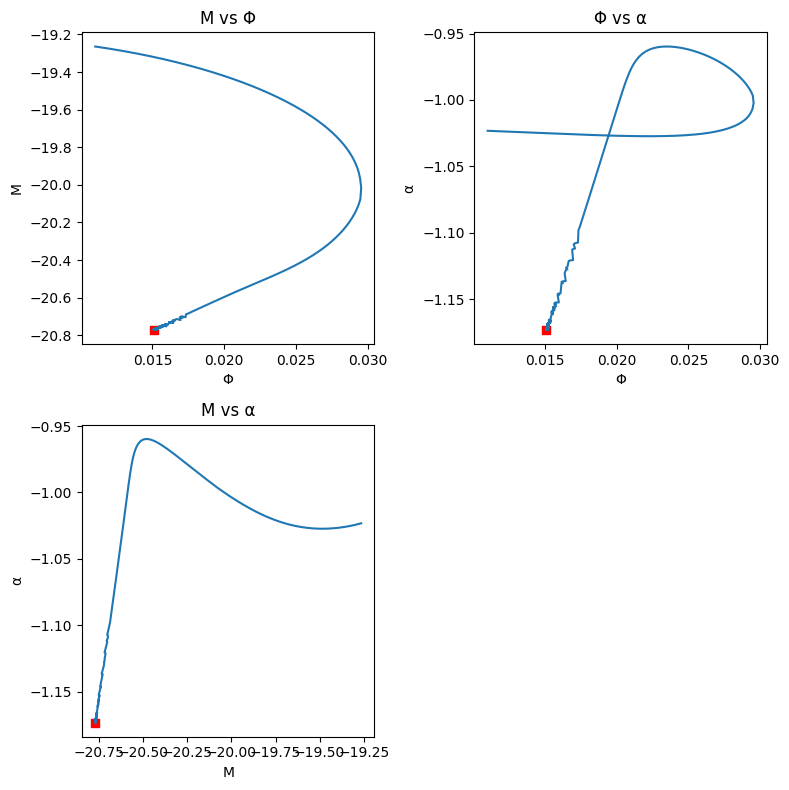

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
fig.delaxes(axs[1, 1])

plt.subplot
ax1.plot(parametros[:,0],parametros[:,1],ms=3)
ax2.plot(parametros[:,0],parametros[:,2],ms=3)
ax3.plot(parametros[:,1],parametros[:,2],ms=3)

ax1.scatter(parametros[-1,0],parametros[-1,1],marker='s',color='red')
ax2.scatter(parametros[-1,0],parametros[-1,2],marker='s',color='red')
ax3.scatter(parametros[-1,1],parametros[-1,2],marker='s',color='red')

ax1.set_ylabel("M")
ax1.set_xlabel("$\Phi$")

ax2.set_xlabel("$\Phi$")
ax2.set_ylabel("α")

ax3.set_xlabel("M")
ax3.set_ylabel("α")

ax1.set_title("M vs $\Phi$")
ax2.set_title("$\Phi$ vs α")
ax3.set_title("M vs α")

plt.tight_layout()
plt.show

Se puede notar que las cadenas convergen mucho mas rápido debido a la no aleatoriedad del salto/paso, pero, tambien vemos que el espacio de parametros no está muy bien muestreado, caso contrario al algoritmo de Metropolis-Hastings, por lo que este algoritmo podria ser muy sensible a otros puntos criticos locales y no globales, convergiendo tal vez en regiones no deseadas. 

In [15]:
philim = [0.005,0.035]
alim = [-1.4,-1.0]
Mlim = [-22,-19]
cadenas=[]
for i in range(20):
        initial_params = [
        np.random.uniform(philim[0], philim[1]), # Φ*
        np.random.uniform(Mlim[0], Mlim[1]),    # M*
        np.random.uniform(alim[0], alim[1])      # α
        ]  
        parametros=gra_des(initial_params[0],initial_params[1],initial_params[2]) # phi, M, alpha
        cadenas.append(parametros)


In [24]:
#Aca quiero ver el ultimo set de parametros de cada cadena y promediarlos a ver que onda
suma = []
for i in range(20):
    suma.append(cadenas[i][-1]) 
    
suma_array = np.array(suma)
resultado = np.sum(suma_array, axis=0)/20
print('El promedio de los ultimos valores es:',resultado)
suma_array

El promedio de los ultimos valores es: [ 1.51173397e-02 -2.07710445e+01 -1.17317073e+00]


array([[ 1.51147889e-02, -2.07709913e+01, -1.17316644e+00],
       [ 1.51163337e-02, -2.07710290e+01, -1.17317047e+00],
       [ 1.51165861e-02, -2.07710345e+01, -1.17317077e+00],
       [ 1.51094699e-02, -2.07708864e+01, -1.17316663e+00],
       [ 1.51181830e-02, -2.07710091e+01, -1.17317884e+00],
       [ 1.51235137e-02, -2.07711760e+01, -1.17317316e+00],
       [ 1.51153263e-02, -2.07710064e+01, -1.17316902e+00],
       [ 1.51219308e-02, -2.07711450e+01, -1.17317337e+00],
       [ 1.51138238e-02, -2.07709709e+01, -1.17316574e+00],
       [ 1.51091152e-02, -2.07708792e+01, -1.17316650e+00],
       [ 1.51149214e-02, -2.07709972e+01, -1.17316835e+00],
       [ 1.51227241e-02, -2.07711598e+01, -1.17317286e+00],
       [ 1.51156689e-02, -2.07710121e+01, -1.17316838e+00],
       [ 1.51199015e-02, -2.07711039e+01, -1.17317286e+00],
       [ 1.51258946e-02, -2.07712281e+01, -1.17317584e+00],
       [ 1.51157373e-02, -2.07710137e+01, -1.17316851e+00],
       [ 1.51248057e-02, -2.07712036e+01

<function matplotlib.pyplot.show(close=None, block=None)>

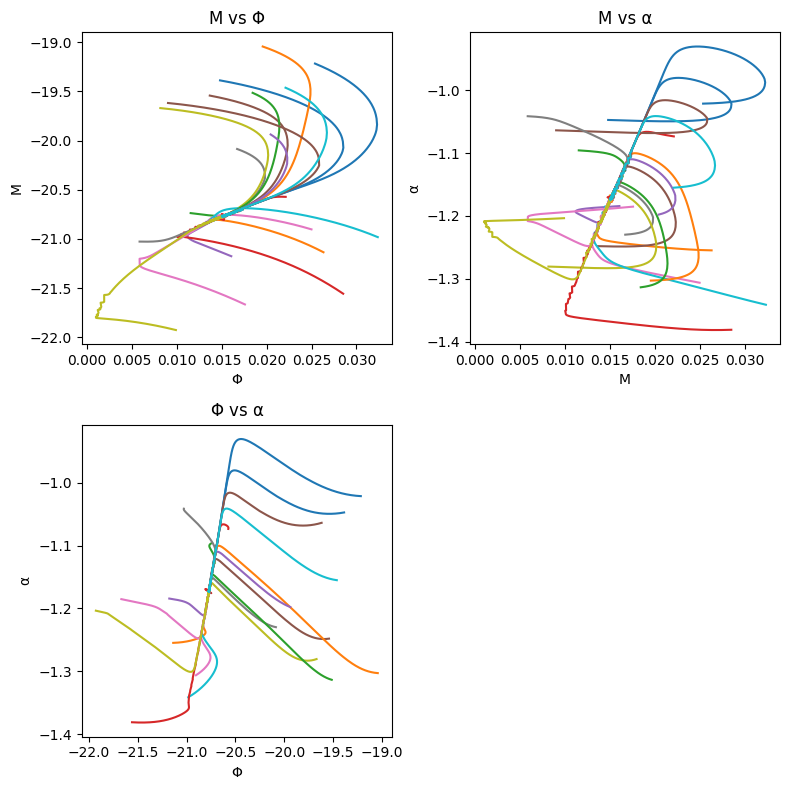

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
fig.delaxes(axs[1, 1])

plt.subplot
for i in range(20):
    ax1.plot(cadenas[i][:,0],cadenas[i][:,1],ms=3)
    ax2.plot(cadenas[i][:,0],cadenas[i][:,2],ms=3)
    ax3.plot(cadenas[i][:,1],cadenas[i][:,2],ms=3)

ax1.set_ylabel("M")
ax1.set_xlabel("$\Phi$")

ax2.set_xlabel("M")
ax2.set_ylabel("α")

ax3.set_xlabel("$\Phi$")
ax3.set_ylabel("α")

ax1.set_title("M vs $\Phi$")
ax2.set_title("M vs α")
ax3.set_title("$\Phi$ vs α")

# Mostrar leyenda y ajustar diseño
plt.tight_layout()
plt.show

In [20]:
import plotly.graph_objects as go
# Crear una figura 3D con plotly
fig = go.Figure()

# Añadir las cadenas al gráfico
for i in range(20):  # Si tienes 10 cadenas en total
    fig.add_trace(go.Scatter3d(
        x=cadenas[i][:, 0],
        y=cadenas[i][:, 1],
        z=cadenas[i][:, 2],
        mode='lines',
        marker=dict(size=3),
        name=f'Cadena {i+1}'
    ))

# Añadir los puntos rojos para el último valor de cada cadena
for i in range(20):
    fig.add_trace(go.Scatter3d(
        x=[cadenas[i][-1, 0]],
        y=[cadenas[i][-1, 1]],
        z=[cadenas[i][-1, 2]],
        mode='markers',
        marker=dict(size=5, color='red'),
        name=f'Último punto cadena {i+1}'
    ))

# Añadir etiquetas y título
fig.update_layout(
    scene=dict(
        xaxis_title='$\Phi$',
        yaxis_title='M',
        zaxis_title='α'
    ),
    title='Gráfico 3D Interactivo de las Cadenas',
)

# Líneas para los parámetros de la literatura
phi_ref = 1.46e-2  # Reemplaza con el valor correspondiente
M_ref = -20.83    # Reemplaza con el valor correspondiente
alpha_ref = -1.2  # Reemplaza con el valor correspondiente

# Agregar la línea para Phi
fig.add_trace(go.Scatter3d(
    x=[phi_ref, phi_ref],
    y=[M_ref, M_ref],
    z=[-1, -1.4],   # Ajusta los valores de α
    mode='lines',
    line=dict(color='black', width=6, dash='dash'),
    name='Parametro Phi (literatura)'
))

# Agregar la línea para M
fig.add_trace(go.Scatter3d(
    x=[0, 0.03],  # Ajusta los valores de Phi
    y=[M_ref, M_ref],
    z=[alpha_ref, alpha_ref],
    mode='lines',
    line=dict(color='black', width=6, dash='dash'),
    name='Parametro M (literatura)'
))

# Agregar la línea para α
fig.add_trace(go.Scatter3d(
    x=[phi_ref, phi_ref],
    y=[-19.5, -22],   # Ajusta los valores de M
    z=[alpha_ref, alpha_ref],
    mode='lines',
    line=dict(color='black', width=6, dash='dash'),
    name='Parametro Alpha (literatura)'
))

# Mostrar el gráfico
fig.show()


Bueno, podemos notar que todas las cadenas convergen al mismo número casi con 3 o 4 cifras significativas, lo que me da una dispersion muuy baja si hago el promedio de estos, tambien vemos que convergen un poco "mas arriba" de los propuestos por Blanton, Que a diferencia del algoritmo de M-H este tenia una mayor dispersion a la hora de converger.


<function matplotlib.pyplot.show(close=None, block=None)>

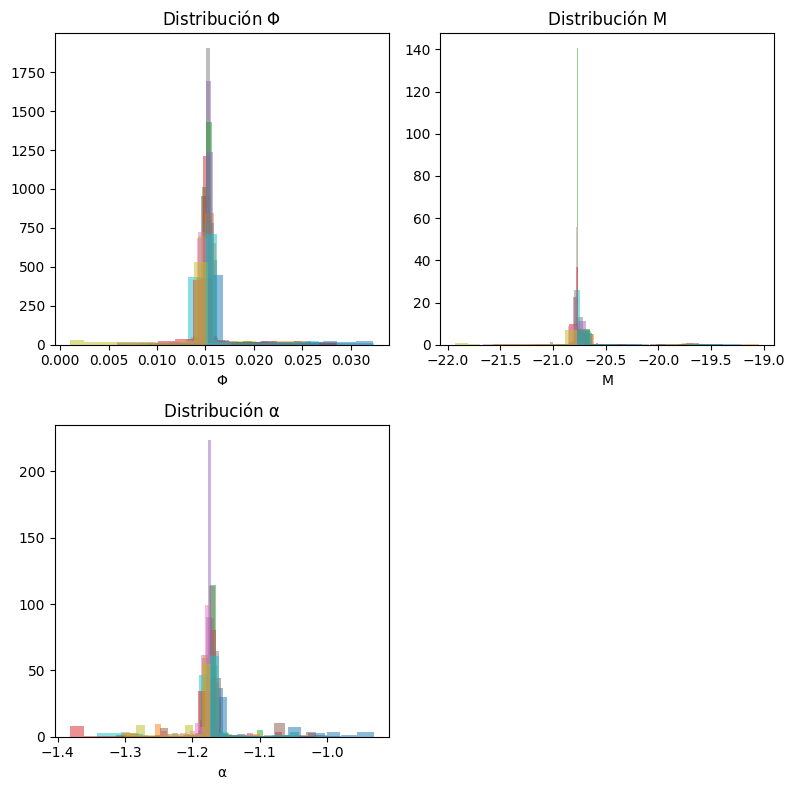

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
fig.delaxes(axs[1, 1])

plt.subplot
for i in range(20):
    ax1.hist(cadenas[i][:,0],density=True, alpha=0.5)
    ax2.hist(cadenas[i][:,1],density=True, alpha=0.5)
    ax3.hist(cadenas[i][:,2],density=True, alpha=0.5)

ax1.set_xlabel("$\Phi$")

ax2.set_xlabel("M")

ax3.set_xlabel("α")

ax1.set_title("Distribución $\Phi$")
ax2.set_title("Distribución M" )
ax3.set_title("Distribución α")

plt.tight_layout()
plt.show

Promedio de Φ: 0.015564893563005305, Desviación estándar de Φ: 0.0026783684505078853
Promedio de M: -20.735865833078762, Desviación estándar de M: 0.25964293089876656
Promedio de α: -1.1727397672226751, Desviación estándar de α: 0.04563241752461993
El promedio de los ultimos valores de las cadenas es: [ 1.51173397e-02 -2.07710445e+01 -1.17317073e+00]


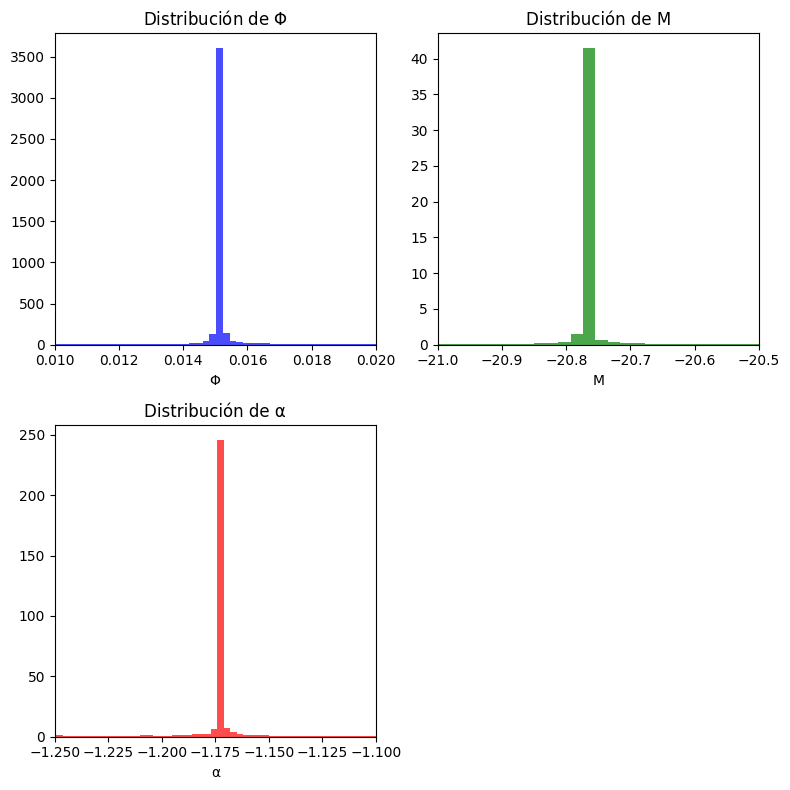

In [25]:
# Concatenar todos los datos para cada parámetro
phi_data = np.concatenate([cadenas[i][:, 0] for i in range(20)])
M_data = np.concatenate([cadenas[i][:, 1] for i in range(20)])
alpha_data = np.concatenate([cadenas[i][:, 2] for i in range(20)])

# Calcular el promedio, la desviación estándar y el sesgo de cada parámetro
phi_mean = np.mean(phi_data)
M_mean = np.mean(M_data)
alpha_mean = np.mean(alpha_data)

phi_std = np.std(phi_data)
M_std = np.std(M_data)
alpha_std = np.std(alpha_data)


# Mostrar los resultados
print(f"Promedio de Φ: {phi_mean}, Desviación estándar de Φ: {phi_std}")
print(f"Promedio de M: {M_mean}, Desviación estándar de M: {M_std}")
print(f"Promedio de α: {alpha_mean}, Desviación estándar de α: {alpha_std}")
print('El promedio de los ultimos valores de las cadenas es:',resultado)

# Crear los gráficos
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
fig.delaxes(axs[1, 1])

# Graficar un solo histograma para cada parámetro
ax1.hist(phi_data, bins=150, density=True, color='blue', alpha=0.7)
ax2.hist(M_data, bins=150, density=True, color='green', alpha=0.7)
ax3.hist(alpha_data, bins=150, density=True, color='red', alpha=0.7)

ax1.set_xlim(0.01,0.02)
ax2.set_xlim(-21,-20.5)
ax3.set_xlim(-1.25,-1.1)

ax1.set_xlabel("$\Phi$")
ax2.set_xlabel("M")
ax3.set_xlabel("α")

ax1.set_title("Distribución de $\Phi$")
ax2.set_title("Distribución de M")
ax3.set_title("Distribución de α")

plt.tight_layout()
plt.show()


Por ultimo podemos ver que el valor promedio calculado concatenando las 20 cadenas, es practicamente indistinguible del calculado promediando los ultimos valores de cada cadena.
Obteniendo:

$$ M_0 = -20.73 \pm 0.25  $$

$$ \phi_0 = (1.55 \pm 0.26) *10^{-2} $$

$$ \alpha_0 = -1.172 \pm 0.045  $$

## Teorema de Bayes

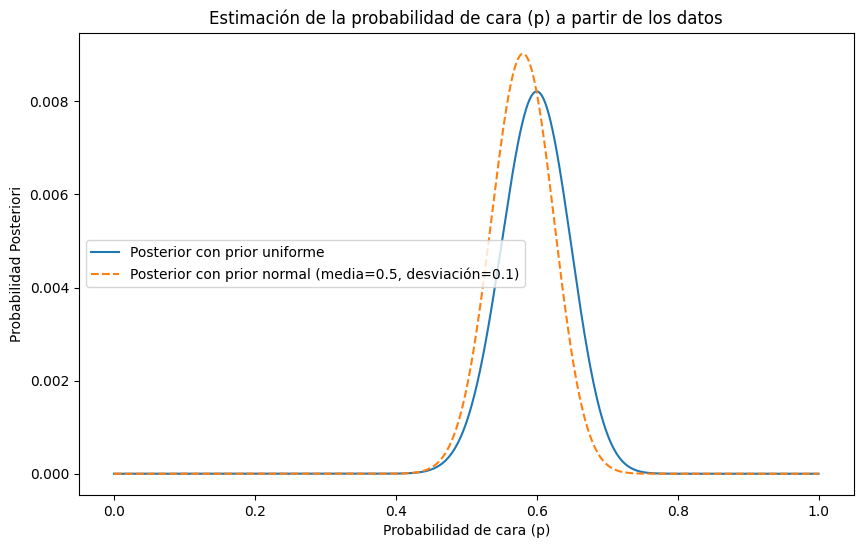

In [28]:
# Definir los parámetros de los experimentos
total_tosses = 100
heads = 60
tails = total_tosses - heads

# Rango de probabilidades
prob_values = np.linspace(0, 1, 1000)

# Prior uniforme
def uniform_prior(prob):
    return 1 if 0 <= prob <= 1 else 0

# Prior normal con media 0.5 y desviación estándar 0.1
def gaussian_prior(prob, mean=0.5, stddev=0.1):
    return norm.pdf(prob, mean, stddev)

# Función de verosimilitud: distribución binomial
def binomial_likelihood(prob, heads, tails):
    return prob**heads * (1 - prob)**tails

# Posterior usando prior uniforme
uniform_posterior = [binomial_likelihood(p, heads, tails) * uniform_prior(p) for p in prob_values]
uniform_posterior /= np.sum(uniform_posterior)  # Normalización

# Posterior usando prior gaussiano
gaussian_posterior = [binomial_likelihood(p, heads, tails) * gaussian_prior(p) for p in prob_values]
gaussian_posterior /= np.sum(gaussian_posterior)  # Normalización

# Graficar las distribuciones posteriori
plt.figure(figsize=(10, 6))
plt.plot(prob_values, uniform_posterior, label="Posterior con prior uniforme")
plt.plot(prob_values, gaussian_posterior, label="Posterior con prior normal (media=0.5, desviación=0.1)", linestyle='--')
plt.xlabel("Probabilidad de cara (p)")
plt.ylabel("Probabilidad Posteriori")
plt.title("Estimación de la probabilidad de cara (p) a partir de los datos")
plt.legend()
plt.show()


En este ejemplo vemos cómo aplicar el teorema de Bayes para actualizar nuestras estimaciones sobre un parámetro, en este caso, la probabilidad de obtener cara en una moneda cargada, basándonos en datos observados. Y se muestra cómo la estimación de la probabilidad "p" varía según el prior elegido.

Estimacion de lamda usando MLE: 0.604367626135252


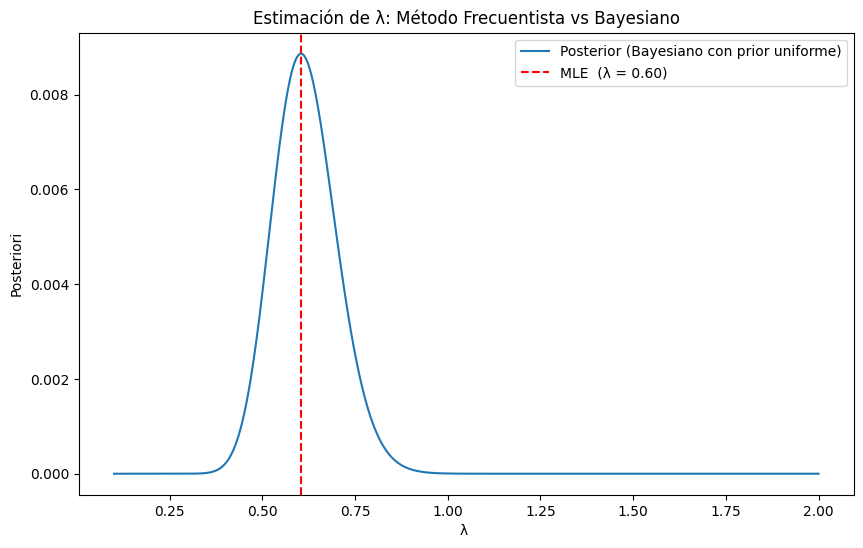

In [32]:
true_lambda = 0.5  
num_samples = 50  

# Simulación de los tiempos de decaimiento
sample_data = np.random.exponential(1 / true_lambda, num_samples)

# Estimación  mediante MLE
mle_lambda = 1 / np.mean(sample_data)
print(f"Estimacion de lamda usando MLE: {mle_lambda}")

# Espacio de valores de lambda
lambda_range = np.linspace(0.1, 2, 1000)

# Función de verosimilitud para los tiempos de decaimiento
def decay_likelihood(lambda_val, data):
    return np.prod(lambda_val * np.exp(-lambda_val * data))

# Prior uniforme
def uniform_prior(lambda_val):
    return 1

# Calcular la posteriori bayesiana con prior uniforme
posterior_bayesian = [decay_likelihood(l, sample_data) * uniform_prior(l) for l in lambda_range]
posterior_bayesian /= np.sum(posterior_bayesian)  # Normalización

# Graficar la posteriori bayesiana y la estimación MLE
plt.figure(figsize=(10, 6))
plt.plot(lambda_range, posterior_bayesian, label="Posterior (Bayesiano con prior uniforme)")
plt.axvline(mle_lambda, color='r', linestyle='--', label=f"MLE  (λ = {mle_lambda:.2f})")
plt.xlabel("λ ")
plt.ylabel("Posteriori")
plt.title("Estimación de λ: Método Frecuentista vs Bayesiano")
plt.legend()
plt.show()